In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from utils_cosm import MHI_Modi2019, MHI_Padmanabhan2017
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

## INITIAL ANALYSIS WORKING ON A SINGLE FILE INSIDE FOLDER LH{i_run}

#### Importing data and visualizing distributions

In [2]:
# Since we are working on a restriced version of the dataset, we should ensure that i_run belongs to [0,9]
# i_z belongs to [0,15]
# i_run refers to the choice of the parameters.Then, for each choice, we have 16 subfiles corresponding to different zs

i_run, i_z = 0, 0 # This means we work using LH_0 and z = 2.63

path_in = './outputs_test/LH_%d/' %(i_run)
path_out = path_in

redshift = np.loadtxt('./outputs_test/redshifts.txt', usecols=(1))
params = np.loadtxt('./outputs_test/params_IllustrisTNG.txt')

z = redshift[i_z]
#t_back = cosmo.lookback_time(z).to(u.Myr)
print('z=%.3f' %(z))

print('Om0	sigma8	Asn1	Aagn1	Asn2	Aagn2')
print(params[i_run])

z=2.630
Om0	sigma8	Asn1	Aagn1	Asn2	Aagn2
[0.309   0.979   3.11234 1.12194 0.6685  0.53182]


In [3]:
# Importing data
f = h5py.File('%sMHI_LH%d_z=%.3f.hdf5' %(path_in, i_run, z))
mHalo = f['MassHalo'][:]
mHI = f['M_HI'][:]
print(mHalo.size)
f.close()

24838


In [4]:
# Generating the simulated data
mass = np.logspace(8, 14, 1000)
mHI_modelA = MHI_Modi2019(Mh=mass, z=z, model='A')
mHI_modelC = MHI_Modi2019(Mh=mass, z=z, model='C')

mHI_Pad = MHI_Padmanabhan2017(Mh=mass, z=z, Om0=params[i_run, 0], delta_c=200.)

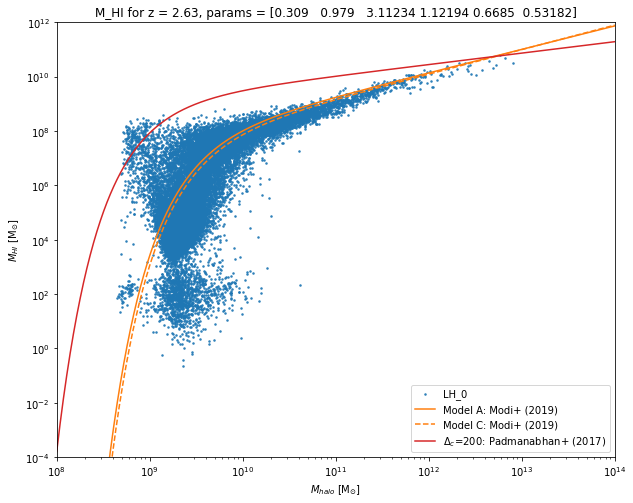

In [5]:
plt.figure(figsize = (10,8))
plt.title('M_HI for z = {}, params = {}'.format(z,params[i_run]))

plt.scatter(x=mHalo, y=mHI, s=10, color='tab:blue', label=r'LH_%d' %i_run, marker='.', alpha=0.8)
plt.plot(mass, mHI_modelA, label='Model A: Modi+ (2019)', color='tab:orange', ls='-')
plt.plot(mass, mHI_modelC, label='Model C: Modi+ (2019)', color='tab:orange', ls='--')
plt.plot(mass, mHI_Pad, label=r'$\Delta_c$=200: Padmanabhan+ (2017)', color='tab:red', ls='-')

plt.xscale('log'), plt.yscale('log')
plt.xlim(1e8, 1e14), plt.ylim(1e-4, 1e12)
plt.xlabel(r'$M_{halo}$ $\rm{[M_{\odot}]}$')
plt.ylabel(r'$M_{HI}$ $\rm{[M_{\odot}]}$')
plt.legend(loc=4)

plt.savefig('%scompare_MHI_LH%d_z%.3f.png' %(path_out, i_run, z), bbox_inches='tight', facecolor='white')
plt.show()

In this first analysis we consder M_HI as a known feature. In order to reply the pipeline described in the tutorial, we first need to discretize the continuos feature. It seems reasonable, considering the scatter plot above, to categorize the variable defining bins using quantiles. To this extent, we use pd.qcut.

We first need to impor the data. To better handle them, we decide to create a dataframe starting from the data in the analysed file.

In [250]:
# Defining feature names

new_features = ['MassHalo','VelHalo','Nsubs','MassBH','dotMassBH','PosHalo',
                'MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0',
                'MetalsStar_1','MetalsStar_2','SFR','M_HI']

# Defining a new dataset

f = h5py.File('%sMHI_LH%d_z=%.3f.hdf5' %(path_in, i_run, z))

MHalo = f['MassHalo']
VelHalo = f['VelHalo']
Nsubs = f['Nsubs']
MassBH = f['MassBH']
dotMassBH = f['dotMassBH']
posHalo = f['PosHalo']
MetalsGas = f['MetalsGas']
MetalsStar = f['MetalsStar']
SFR = f['SFR']
M_HI = f['M_HI']

data = np.empty((MHalo.size,len(new_features)))

data[:,0] = MHalo

# Instead of saving the velocity of the Halo among each canonical direction, we decide to summarize them by compute 
# the norm of the valocity. By doing so, we not only reduce the dimension of our data (extremely useful to avoid the 
# curse of dimensionality), but we ensure to reduce the computation without losing useful information.

data[:,1] = np.linalg.norm(VelHalo, axis = 1)
data[:,2] = Nsubs
data[:,3] = MassBH
data[:,4] = dotMassBH

# Since the model does not take into account the interaction among different Halos, there is no need to save the coordinates
# along different dimension but it is enough to save the norm of the vector indicating the distance of the Halo from the
# centre of the simulation

data[:,5] = np.linalg.norm(posHalo, axis = 1)

data[:,6] = MetalsGas[:,0]
data[:,7] = MetalsGas[:,1]
data[:,8] = MetalsGas[:,2]
data[:,9] = MetalsStar[:,0]
data[:,10] = MetalsStar[:,1]
data[:,11] = MetalsStar[:,2]
data[:,12] = SFR
data[:,13] = M_HI

df_original = pd.DataFrame(data, columns = new_features)
print(df_original.describe())
df_original.sample(5)
df = df_original.copy()
    

           MassHalo       VelHalo         Nsubs        MassBH     dotMassBH  \
count  2.483800e+04  24838.000000  24838.000000  2.483800e+04  2.483800e+04   
mean   1.384219e+10    178.550590      0.939689  2.161897e+05  1.840804e+05   
std    1.200604e+11     88.485080      1.036897  8.205954e+06  9.247971e+06   
min    4.398577e+08      7.465858      0.000000  0.000000e+00  0.000000e+00   
25%    1.951664e+09    114.859684      1.000000  0.000000e+00  0.000000e+00   
50%    3.120521e+09    164.212830      1.000000  0.000000e+00  0.000000e+00   
75%    6.342715e+09    226.551731      1.000000  0.000000e+00  0.000000e+00   
max    7.991448e+12    690.334167     53.000000  8.933110e+08  1.264435e+09   

            PosHalo   MetalsGas_0   MetalsGas_1   MetalsGas_2  MetalsStar_0  \
count  24838.000000  24838.000000  24838.000000  2.483800e+04  24838.000000   
mean      23.559367      0.759575      0.240014  8.864283e-05      0.062024   
std        6.440471      0.013673      0.004344  4.

We discretize the variable 'M_HI'.

In [7]:
df.M_HI.describe()

count    2.483800e+04
mean     1.184573e+08
std      9.833928e+08
min      0.000000e+00
25%      2.305985e+04
50%      1.238574e+06
75%      5.010041e+07
max      6.178740e+10
Name: M_HI, dtype: float64

In [251]:
# We not only use the canonical quantiles but also 5% quantle to create a class of halos having unusually low hidrogen
df['M_HI'] = pd.qcut(df.M_HI,[0,.05,.25,.5,.75,1], labels = ['extremely_low_HI','very_low_HI','low_HI','high_HI','very_high_HI'])
df.sample(5)

,MassHalo,VelHalo,Nsubs,MassBH,dotMassBH,PosHalo,MetalsGas_0,MetalsGas_1,MetalsGas_2,MetalsStar_0,MetalsStar_1,MetalsStar_2,SFR,M_HI
16187,2.347199e+09,137.153473,1.0,0.0000,0.000000,22.951925,0.760000,0.240000,8.000000e-10,0.000000,0.000000,0.000000,0.000000,low_HI
250,1.676096e+11,47.095329,2.0,837791.3125,54958.476562,20.639103,0.759426,0.240232,3.413867e-04,0.758899,0.240199,0.000902,0.331533,very_high_HI
9191,4.497952e+09,160.320404,1.0,0.0000,0.000000,27.027657,0.760000,0.240000,8.000000e-10,0.000000,0.000000,0.000000,0.000000,high_HI
21153,1.684663e+09,374.173309,0.0,0.0000,0.000000,23.016903,0.760000,0.240000,8.000000e-10,0.000000,0.000000,0.000000,0.000000,very_low_HI
18736,1.903146e+09,167.041122,0.0,0.0000,0.000000,27.547400,0.760000,0.240000,7.677856e-10,0.000000,0.000000,0.000000,0.000000,very_low_HI


In [9]:
# Computing the cardinality of each subset
df.groupby('M_HI')['M_HI'].count()

M_HI
extremely_low_HI    1242
very_low_HI         4968
low_HI              6209
high_HI             6209
very_high_HI        6210
Name: M_HI, dtype: int64

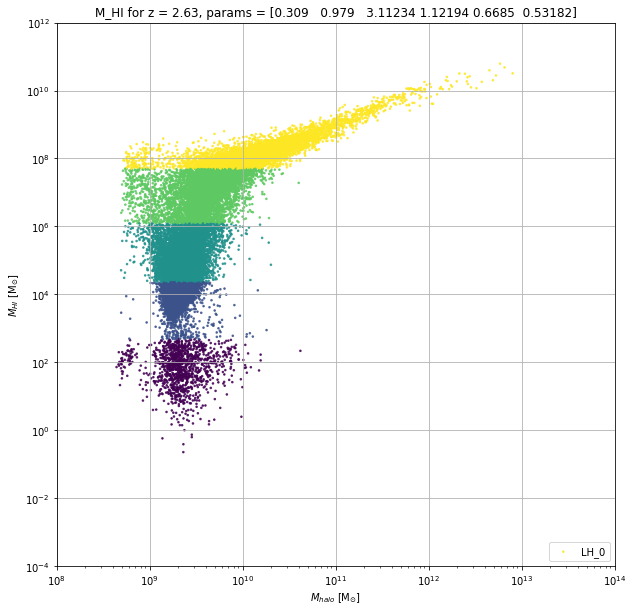

In [252]:
# Defining colors starting from the classification

dic = {'extremely_low_HI':0,'very_low_HI':1, 'low_HI':2, 'high_HI':3, 'very_high_HI':4}
col = list(map(lambda x: dic[x], df['M_HI'].values))

# Visualizing how discretization is a partition of our data
plt.figure(figsize = (10,10))
plt.scatter(x=mHalo, y=mHI, s=10, c = col, label=r'LH_%d' %i_run, marker='.', alpha=0.8)
plt.xscale('log'), plt.yscale('log')
plt.xlim(1e8, 1e14), plt.ylim(1e-4, 1e12)
plt.xlabel(r'$M_{halo}$ $\rm{[M_{\odot}]}$')
plt.ylabel(r'$M_{HI}$ $\rm{[M_{\odot}]}$')
plt.grid()
plt.title('M_HI for z = {}, params = {}'.format(z,params[i_run]))
plt.legend(loc=4)

'MetalsGas' and 'MetalsStar' seem to be very concentrated unless for very few observations. We decide to visualize the distributions of these features to better understand how to handle them.

In [11]:
df[['MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0','MetalsStar_1','MetalsStar_2']].describe()

,MetalsGas_0,MetalsGas_1,MetalsGas_2,MetalsStar_0,MetalsStar_1,MetalsStar_2
count,24838.000000,24838.000000,2.483800e+04,24838.000000,24838.000000,24838.000000
mean,0.759575,0.240014,8.864283e-05,0.062024,0.019621,0.000045
std,0.013673,0.004344,4.858848e-04,0.207960,0.065787,0.000522
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.759998,0.240000,8.000000e-10,0.000000,0.000000,0.000000
50%,0.760000,0.240000,8.340466e-10,0.000000,0.000000,0.000000
75%,0.760000,0.240001,1.091075e-06,0.000000,0.000000,0.000000
max,0.760000,0.251941,1.432272e-02,0.760000,0.249917,0.021299


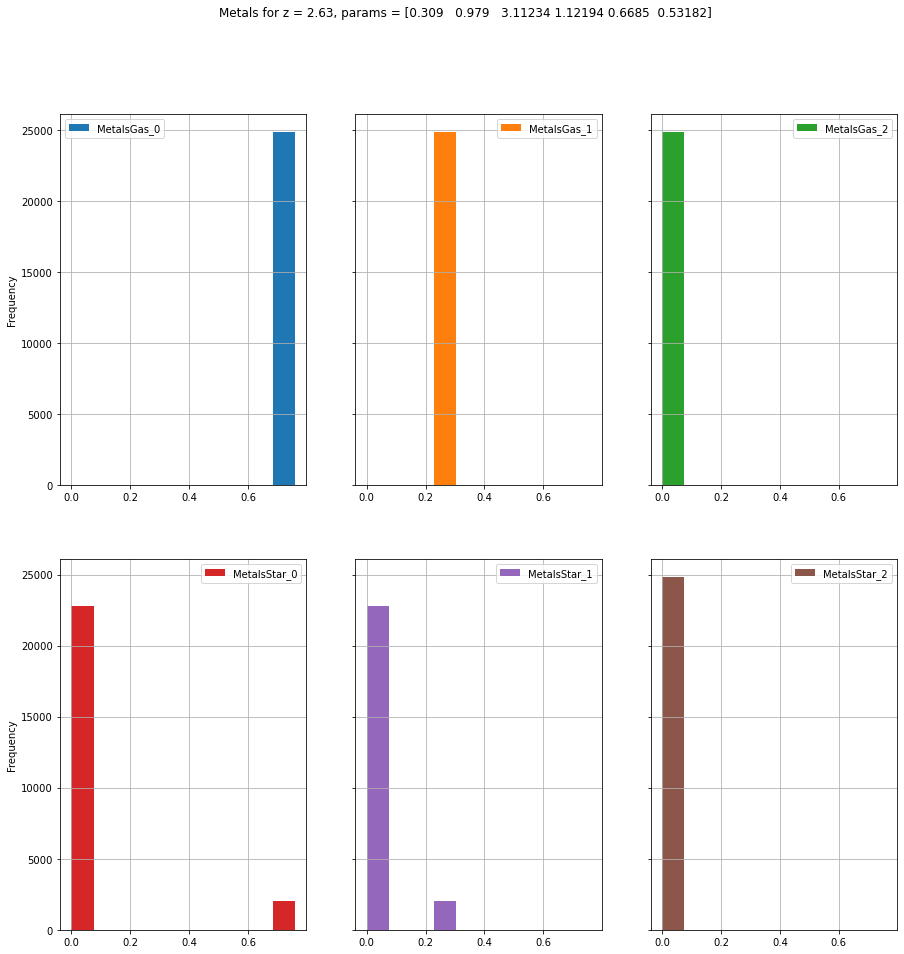

In [12]:
analysed_columns = ['MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0','MetalsStar_1','MetalsStar_2']
df[analysed_columns].plot(kind = 'hist',subplots = True, figsize = (15,15), layout = (2,3), sharey = True,
                          sharex = False, grid = True, title = 'Metals for z = {}, params = {}'.format(z,params[i_run]))
plt.show()

From the previous analysis we notice that, except for few observations, the analysed features tend to mantain the same value. Since they are not so discriminant, we avoid to use them in the following plot showing the distributions of each features and the scatter plot of every pair of variables.

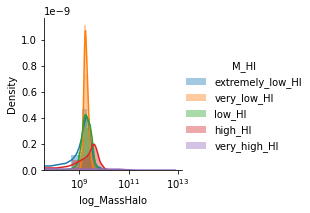

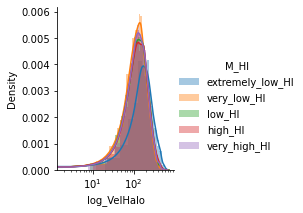

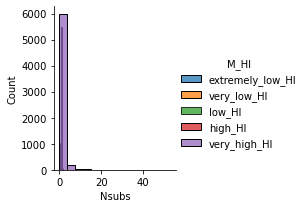

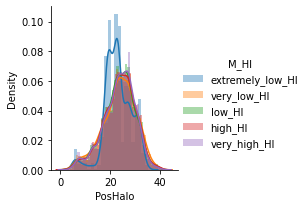

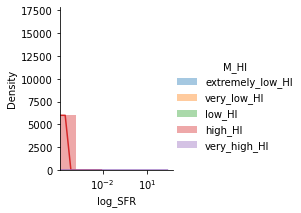

In [254]:
sns.FacetGrid(df,hue="M_HI",height=3).map(sns.distplot,"MassHalo").add_legend()
plt.xscale('log')
plt.xlabel('log_MassHalo')
sns.FacetGrid(df,hue="M_HI",height=3).map(sns.distplot,"VelHalo").add_legend()
plt.xscale('log')
plt.xlabel('log_VelHalo')
sns.FacetGrid(df,hue="M_HI",height=3).map(sns.histplot,"Nsubs").add_legend()
sns.FacetGrid(df,hue="M_HI",height=3).map(sns.distplot,"PosHalo").add_legend()
sns.FacetGrid(df,hue="M_HI",height=3).map(sns.distplot,"SFR").add_legend()
plt.xscale('log')
plt.xlabel('log_SFR')
plt.show()

We proceed to plot the distributions of each feature and the plot of each pair of feature in order to compute some preliminar analysis.

We notice important relationships:
- even though Nsubs tends to assume values lower than 20/25, the higher MassHalo is, the higher Nsubs is (and also M_HI);


- there seems to be a positive correlation between SFR and MassHalo (pearson_coefficient = 0.7756);


- VelHalo seems not to carry much information, unless the fact that whenever MHI and MassHalo are high,the speed seems to be above the average value


- dotMassBH seems to be positively correlated with SFR (pearson_coefficient = 0.8056);


- PosHalo seems not to introduce a substantial difference among categories.

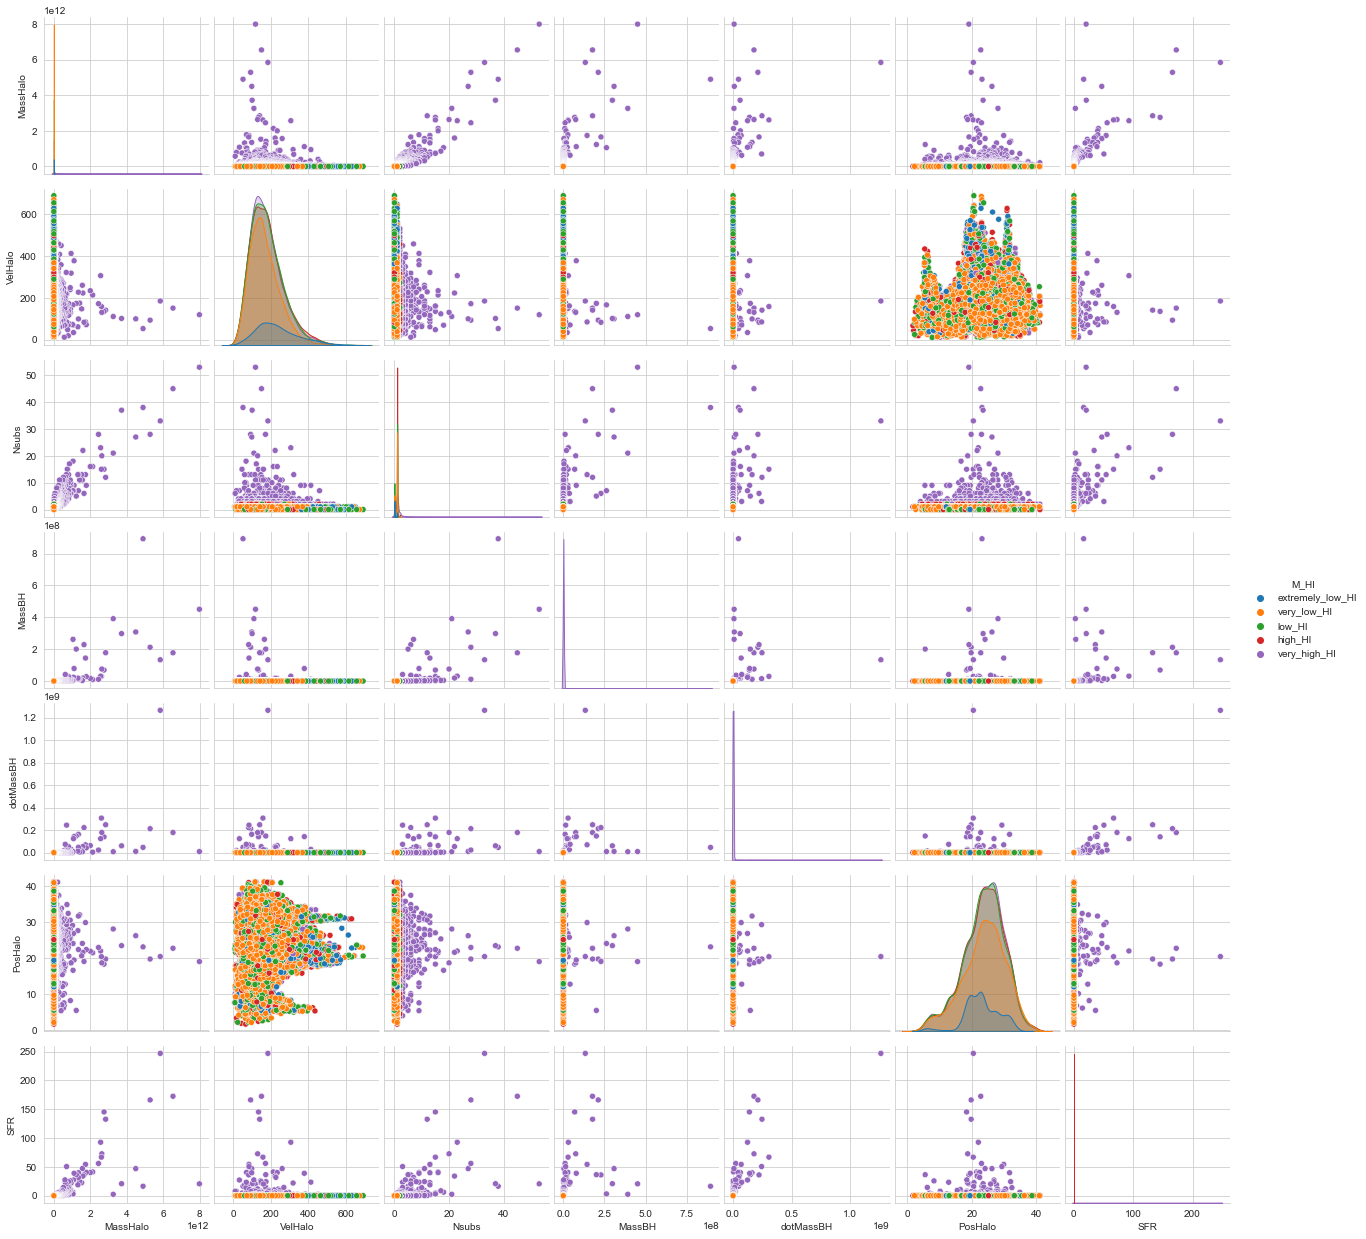

In [147]:
final_columns = ['MassHalo','VelHalo','Nsubs','MassBH','dotMassBH','PosHalo','SFR','M_HI']
sns.set_style("whitegrid")
sns.pairplot(df[final_columns],hue="M_HI")

#### Computing KMeansClustering to identify clusters and pattern/regularities in data

From the previous plot we notice a certain number of clusters in the data. Supposing not to know the actual value of M_HI, we want to use an unsupervised learning algorithm to label each data point. We expect that the actual aclssification returns a categorization which is different from the one made by us. While we only focus on the numerical value assumed by M_HI, we now want to capture regularities in the data. 

We define the dataset we need. Considering the observations above, we decide not to consider MetalsGas, MetalsStar, PosHalo and VelHalo, since they do not seem to carry useful information. Dimensionality reduction, provided that it does not waste any useful information, is a great way to avoid the curse of dimensionality when using KMeansClutering.

Before starting, we notice two main problems:
- MassHalo must be rescaled since its values are far higher than the others. If we do not do so, the method will overoptimize w.r.t this only variable;


- we need to rescale the other mass values so that we can consider only their magnitude;


- using a 1-hot encoding to deal with Nsubs is not efficient (the dimension of the feature space grows and we suffer from the Curse of Dimensionality)

In [263]:
X = df[['MassHalo','MassBH','dotMassBH','SFR','Nsubs']]
X['MassHalo'] = np.log10(X.MassHalo)
X['dotMassBH'] = np.log10(1 + X.dotMassBH)
X['MassBH'] = np.log10(1 + X.MassBH)
X['MassHalo'] = ( X.MassHalo - X.MassHalo.mean() ) /  X.MassHalo.std()
X['MassBH'] = ( X.MassBH - X.MassBH.mean() ) /  X.MassBH.std()
X['dotMassBH'] = ( X.dotMassBH - X.dotMassBH.mean() ) /  X.dotMassBH.std()
X['SFR'] = ( X.SFR - X.SFR.mean() ) /  X.SFR.std()
X.head()

,MassHalo,MassBH,dotMassBH,SFR,Nsubs
0,7.168572,7.552946,8.941572,7.007295,53.0
1,6.979418,7.190452,10.639494,59.081580,45.0
2,6.872502,7.080316,11.753337,84.568084,33.0
3,6.777977,7.260091,10.738031,56.890561,28.0
4,6.705832,7.818657,9.872143,5.588313,38.0


We train various models saving the corresponding inertia (weighted sum of squared distances of points from their centroids).
As done in Kaggle tutorial, we use k-means++ to initialize our centroids in a clever way.

In [264]:
# We define a list to store the inertia values corresponding to each model
wcss = []

for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

We now visualize the curve in order to choose the optimal K (hyperparameter).

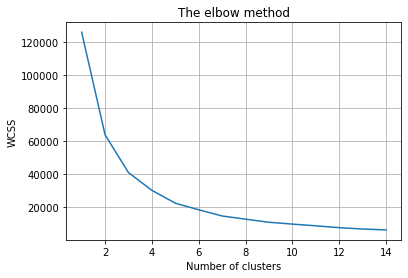

In [265]:
plt.plot(range(1, 15), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.grid()
plt.show()

K = 6 appear to be a good choice, since the curve reaches its plateau.

After choosing the best K, we proceed to use KMeansClustering to assign label to each data point.

In [266]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)

In order to visualize the results we obtained, we visualize the first scatterplot assigning different labels to each point with respect to the label assigned by the unsupervised algorithm.

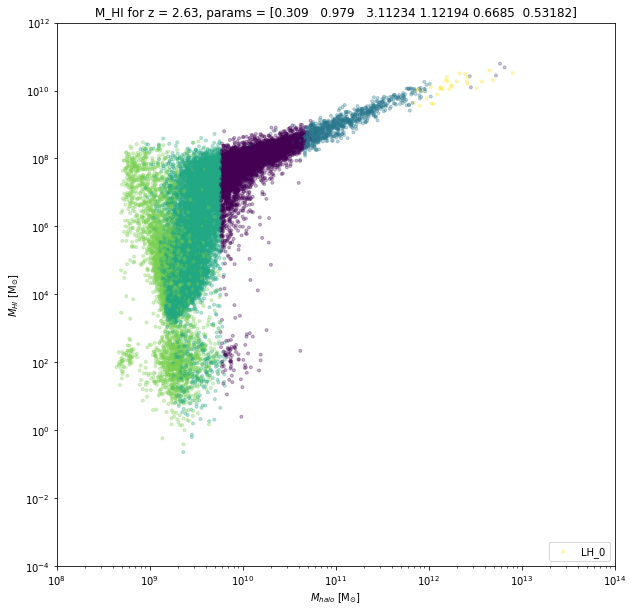

In [267]:
# Generating the simulated data
plt.figure(figsize = (10,10))
plt.scatter(x=mHalo, y=mHI, c = y_kmeans, label=r'LH_%d' %i_run, marker='.', alpha=0.3)
plt.xscale('log'), plt.yscale('log')
plt.xlim(1e8, 1e14), plt.ylim(1e-4, 1e12)
plt.xlabel(r'$M_{halo}$ $\rm{[M_{\odot}]}$')
plt.ylabel(r'$M_{HI}$ $\rm{[M_{\odot}]}$')
plt.title('M_HI for z = {}, params = {}'.format(z,params[i_run]))
plt.legend(loc=4)

We notice that, despite we can easily visualize more than one cluster in the previous plot, KMeansCLustering is not able to find them. There might be a possible reason behind the result: while large values of MassHalo suggest large presence of neutral hidrogen, for smaller values of MassHalo it is not easy anymore to deduce the value of M_HI. If we refer to the pairplot analysed before, we notice that, for halos having mass in the range [10^9, 19^11], the other features do not seem to introduce substantial differences that can legitimate the definition of a new centroid. Therefore, the problem we are focusing on seems to be lacking the assumption of spatial relationship that are necessary for  good fitting when using KMeansClustering.